In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [2]:
from statiskit import (linalg,
                       core,
                       pgm)

In [3]:
import math
import os

In [4]:
%reload_ext rpy2.ipython

In [5]:
%%R
library(glasso)

In [6]:
if not 'K' in os.environ:
    os.environ['K'] = str(20)
K = int(os.environ.get('K'))
simulation = !jupyter nbconvert --ExecutePreprocessor.timeout=3600 --to notebook --execute sampling.ipynb --output sampling.ipynb
data = core.read_csv('data.csv')
truth = pgm.read_gml('graph.gml')

In [7]:
if not 'PENALTIES' in os.environ:
    os.environ['PENALTIES'] = str(K)
PENALTIES = int(os.environ.get('PENALTIES'))

In [8]:
import itertools
import numpy
import math
S = data.covariance
for u in range(K):
    S[u, u] = float("nan")
    for v in range(u):
        S[u, v] = math.fabs(S[u, v])
        S[v, u] = S[u, v]
rhos = dict(data = core.from_list(list(itertools.chain(*S.to_list()))))
rhos['linear'] = numpy.linspace(rhos['data'].min.value, rhos['data'].max.value, PENALTIES).tolist()
freq = core.frequency_estimation(data=rhos['data'])
rhos['empirical'] = [freq.estimated.quantile(rho) for rho in numpy.linspace(0., 1., PENALTIES)]
del rhos['data']

In [9]:
%R data = read.csv('data.csv', header = F, sep="") 
%R -n S = cov(data)

In [10]:
graphs = dict()
for path in rhos:
    graphs[path] = []
    for rho in rhos[path]:
        %R -i rho
        theta = %R glasso(S, rho=rho)$wi
        graphs[path].append(pgm.UndirectedGraph(linalg.Matrix(theta)))
    graphs[path] = sorted(graphs[path], key = lambda graph: graph.nb_edges)

In [11]:
def TP(truth, predicted):
    tp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and predicted.has_edge(u, v):
                tp += 1
    return tp

def TN(truth, predicted):
    tn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and not predicted.has_edge(u, v):
                tn += 1
    return tn

def FP(truth, predicted):
    fp = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if not truth.has_edge(u, v) and predicted.has_edge(u, v):
                fp += 1
    return fp

def FN(truth, predicted):
    fn = 0
    for u in range(truth.nb_vertices):
        for v in range(u):
            if truth.has_edge(u, v) and not predicted.has_edge(u, v):
                fn += 1
    return fn

def ROC(truth, graphs):
    x = []
    y = []
    for graph in graphs:
        tp, tn, fp, fn = TP(truth, graph), TN(truth, graph), FP(truth, graph), FN(truth, graph)
        try:
            x.append(fp / float(tn + fp))
        except:
            pass
        else:
            try:
                y.append(tp / float(tp + fn))
            except:
                x.pop()
    return x, y

ROCs = {path : ROC(truth, graphs[path]) for path in graphs}

<IPython.core.display.Javascript object>


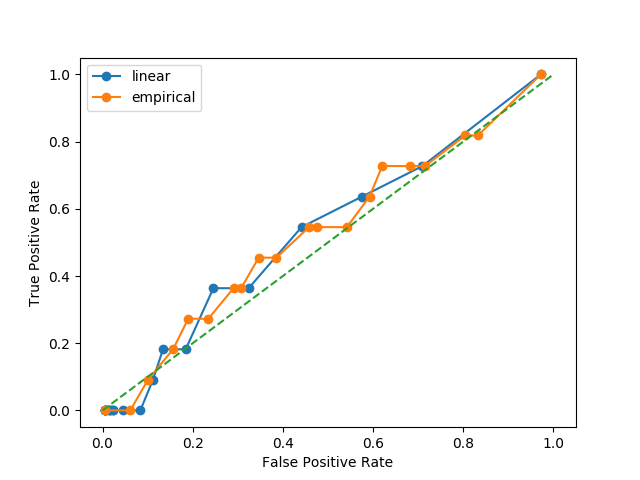

In [12]:
fig = pyplot.figure()
axes = fig.add_subplot(1, 1, 1)
for path in graphs:
    axes.plot(*ROCs[path], marker='o', linestyle='-', label=path)
axes.plot([0, 1], [0, 1], linestyle='--')
axes.legend()
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")

<IPython.core.display.Javascript object>


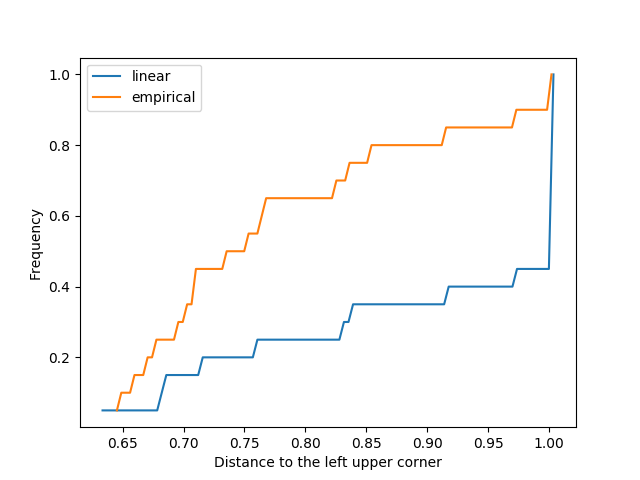

In [13]:
fig = pyplot.figure()
axes = fig.add_subplot(1, 1, 1)

def d(x, y):
    return (x**2 + (1 - y)**2)**(1 / 2.)

for path in graphs:
    data = core.UnivariateDataFrame(core.controls.RR)
    for xy in zip(*ROCs[path]):
        data.add_event(core.ContinuousElementaryEvent(d(*xy)))
    data.cdf_plot(axes=axes, label=path, norm=1.)
# axes.plot([0, 1], [0, 1], linestyle='--')
axes.legend()
axes.set_xlabel("Distance to the left upper corner")
axes.set_ylabel("Frequency")

In [14]:
import hashlib
from datetime import datetime
identifier = hashlib.md5(str(datetime.today())).hexdigest()
if not os.path.exists('paths.csv'):
    with open('paths.csv', 'w') as filehandler:
        filehandler.write('identifier,dimension,path,TP,TN,FP,FN\n')
with open('paths.csv', 'a') as filehandler:
    for path in graphs:
        for graph in graphs[path]:
            tp, tn, fp, fn = TP(truth, graph), TN(truth, graph), FP(truth, graph), FN(truth, graph)
            filehandler.write(','.join([identifier, str(K), str(path), str(tp), str(tn), str(fp), str(fn)]) + '\n')

In [15]:
os.remove('graph.gml')
os.remove('data.csv')